In [1]:
import pandas as pd
import numpy as np
import utils as u
import matplotlib.pyplot as plt
import scipy.stats as stat
import empiricaldist as ed

In [5]:
df = pd.read_csv('space.csv', parse_dates=[0])

# avoiding column names with spaces
df.rename(columns={'Damage Incident': 'Damage'}, inplace=True)

# dropping row 3, in which Damage Incident is NaN,
# and row 24, which is the record for the Challenger
df.drop(labels=[3, 24], inplace=True)

# convert the Damage column to integer
df['Damage'] = df['Damage'].astype(int)

df

,Date,Temperature,Damage
0,1981-04-12,66,0
1,1981-11-12,70,1
2,1982-03-22,69,0
4,1982-01-11,68,0
5,1983-04-04,67,0
6,1983-06-18,72,0
7,1983-08-30,73,0
8,1983-11-28,70,0
9,1984-02-03,57,1
10,1984-04-06,63,1


In [6]:
def plot_data(data):
    """Plot damage as a function of temperature.
    
    data: DataFrame
    """
    plt.plot(data['Temperature'], data['Damage'], 'o', 
             label='data', color='C0', alpha=0.4)

    u.decorate(ylabel="Probability of damage",
         xlabel="Outside temperature (deg F)",
         title="Damage to O-Rings vs Temperature")

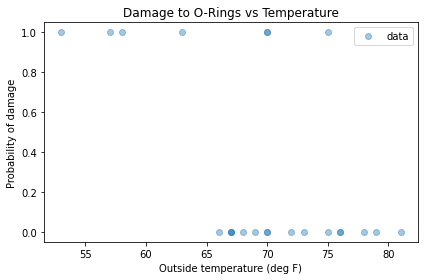

In [7]:
plot_data(df)

When the outside temperature was below 65 degrees, there was always damage to the O-rings. When the temperature was above 65 degrees, there was usually no damage.

Based on this figure, it seems plausible that the probability of damage is related to temperature. If we assume this probability follows a logistic model, we can write:

log(P(H|x)) = beta0 + beta1*x; where x is temperature

In [45]:
offset = df['Temperature'].mean()
std = df['Temperature'].std()
df['x'] = (df['Temperature'] - offset)/std
df['x'].describe()

count    2.300000e+01
mean     5.309762e-16
std      1.000000e+00
min     -2.347319e+00
25%     -3.634956e-01
50%      6.160942e-02
75%      7.701178e-01
max      1.620328e+00
Name: x, dtype: float64

c:\Users\marek.kancir\Anaconda3\envs\scraping_env\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='Temperature', ylabel='x'>

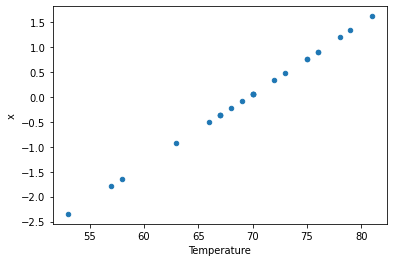

In [71]:
df[["Temperature", 'x']].plot(x='Temperature', y='x', kind='scatter')

In [46]:
df['y'] = df['Damage']

In [47]:
import statsmodels.formula.api as smf

formula = 'y ~ x'
results = smf.logit(formula, data=df).fit(disp=False)
results.params

Intercept   -1.107550
x           -1.638391
dtype: float64

In [48]:
inter = results.params['Intercept']
slope = results.params['x']
xs = (np.arange(53, 83) - offset)/std

log_odds = inter + slope * xs
odds = np.exp(log_odds)
ps = odds / (odds + 1)


In [49]:
from scipy.special import expit
# Converting log odds to probabilities is a common enough operation that it has a name, expit, and SciPy provides a function that computes it.
ps = expit(inter + slope * xs)

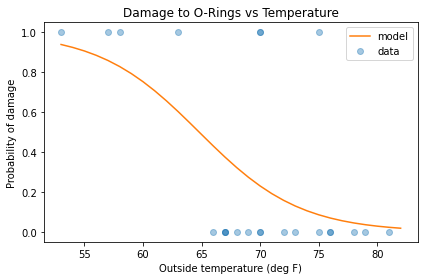

In [52]:
plt.plot(xs*std + offset, ps, label='model', color='C1')

plot_data(df)

At low temperatures, the probability of damage is high; at high temperatures, it drops off to near 0.

But that’s based on conventional logistic regression. Now we’ll do the Bayesian version.

## Bayesian model

I’ll use uniform distributions for both parameters, using the point estimates from the previous section to help me choose the upper and lower bounds.

In [109]:
prior_inter = u.make_uniform(
    np.linspace(-5, 2, 101),
    'intercept'
)
prior_temp = u.make_uniform(
    np.linspace(-7, 2, 101),
    'temperature'
)

prior_joint = u.make_joint(
    prior_inter, prior_temp
)
prior_joint

intercept,-5.00,-4.93,-4.86,-4.79,-4.72,-4.65,-4.58,-4.51,-4.44,-4.37,...,1.37,1.44,1.51,1.58,1.65,1.72,1.79,1.86,1.93,2.00
temperature,,,,,,,,,,,,,,,,,,,,,
-7.00,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
-6.91,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
-6.82,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
-6.73,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
-6.64,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.64,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
1.73,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
1.82,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098


In [110]:
joint_pmf = ed.Pmf(prior_joint.stack())
joint_pmf.head()

temperature  intercept
-7.0         -5.00        0.000098
             -4.93        0.000098
             -4.86        0.000098
Name: , dtype: float64

### Likelihood

To do the update, we have to compute the likelihood of the data for each possible pair of parameters.
To make that easier, I’m going to group the data by temperature, x, and count the number of launches and damage incidents at each temperature.

The result is a DataFrame with two columns: count is the number of launches at each temperature; sum is the number of damage incidents. To be consistent with the parameters of the binomial distributions, I’ll assign them to variables named ns and ks.

In [111]:
grouped = df.groupby('x')['y'].agg(['count', 'sum'])

ns = grouped['count']
ks = grouped['sum']
xs = grouped.index

In [112]:
likelihood = joint_pmf.copy()

# The loop iterates through the parameters. For each possible pair, 
# it uses the logistic model to compute ps, computes the likelihood of the data, and assigns the result to a row in likelihood.
for slope, inter in joint_pmf.index:
    ps = expit(inter + slope * xs)
    # Each element of likes is the probability of seeing k damage incidents in n launches 
    # if the probability of damage is p. The likelihood of the whole dataset is the product of this array.
    likes = stat.binom.pmf(ks, ns, ps)
    likelihood[slope, inter] = likes.prod() 

posterior_pmf = joint_pmf * likelihood
posterior_pmf.normalize()

2.126136347888622e-05

In [113]:
print('Bayesian estimate:\n', pd.Series(posterior_pmf.max_prob(),
          index=['slope', 'inter']))

print('Statsmodels estimate:\n', results.params)

Bayesian estimate:
 slope   -1.60
inter   -1.08
dtype: float64
Statsmodels estimate:
 Intercept   -1.107550
x           -1.638391
dtype: float64


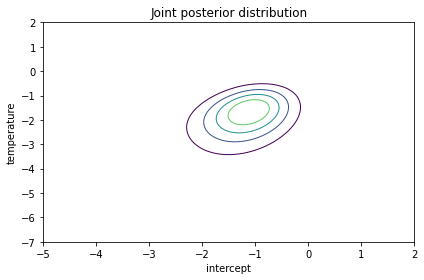

In [114]:
joint_posterior = posterior_pmf.unstack()
u.plot_contour(joint_posterior)
u.decorate(title='Joint posterior distribution')

The ovals in the contour plot are aligned along a diagonal, which indicates that there is some correlation between slope and inter in the posterior distribution.

But the correlation is weak, which is one of the reasons we subtracted off the mean launch temperature when we computed x; centering the data minimizes the correlation between the parameters.
In theory, this correlation is not a problem, but in practice it is. With uncentered data, the posterior distribution is more spread out, so it’s harder to cover with the joint prior distribution. Centering the data maximizes the precision of the estimates; with uncentered data, we have to do more computation to get the same precision.

*I have done standardization to lower correlation even more*

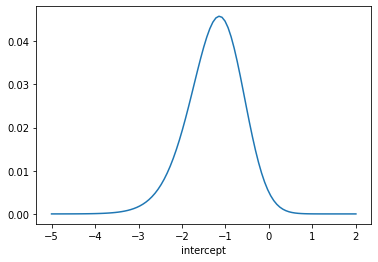

<AxesSubplot: xlabel='temperature'>

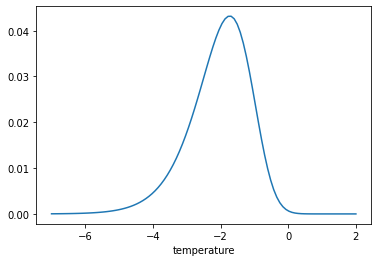

In [115]:
marginal_inter = u.marginal(joint_posterior, 0)
marginal_slope = u.marginal(joint_posterior, 1)

marginal_inter.plot()
plt.show()
plt.close()

marginal_slope.plot()

In [116]:
pd.Series([marginal_inter.mean(), marginal_slope.mean()],
          index=['inter', 'slope'])

inter   -1.251755
slope   -2.051864
dtype: float64

Both marginal distributions are moderately skewed, so the posterior means are somewhat different from the point estimates.

## Interpretation

Let’s interpret these parameters. Recall that the intercept is the log odds of the hypothesis when  is 0, which is when temperature is about 69.5 degrees F (the value of offset). So we can interpret the quantities in marginal_inter as log odds.

true for standardization,too -> 0 = (temp - mu)/std -> temp = mu

In [117]:
marginal_probs = marginal_inter.transform(expit) # log -> probs

# let’s look more closely at the estimated slope. In the logistic model, the parameter beta1 is the log of the likelihood ratio.
# So we can interpret the quantities in marginal_slope as log likelihood ratios, and we can use exp to transform them to likelihood ratios (also known as Bayes factors).
marginal_lr = marginal_slope.transform(np.exp)

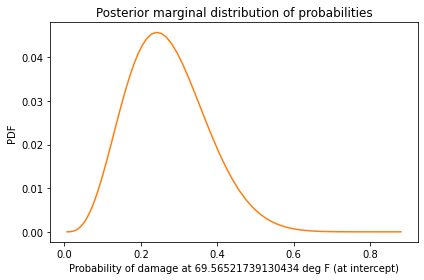

In [120]:
marginal_probs.plot(color='C1')

u.decorate(xlabel=f'Probability of damage at {offset} deg F (at intercept)',
         ylabel='PDF',
         title='Posterior marginal distribution of probabilities')

In [119]:
# mean = probability of damage at offset
marginal_probs.mean()

0.2399190570026357

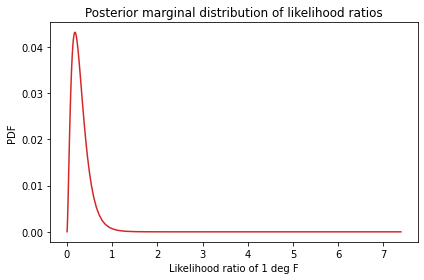

In [101]:
marginal_lr.plot(color='C3')

u.decorate(xlabel='Likelihood ratio of 1 deg F',
         ylabel='PDF',
         title='Posterior marginal distribution of likelihood ratios')

In [129]:
marginal_lr.mean()

0.18063432410431407

The mean of this distribution is about 0.18, which means that each additional degree Fahrenheit provides evidence against the possibility of damage, with a likelihood ratio (Bayes factor) of 0.18.

As a general rule, transform first, then compute summary statistics.

## Predictive Distribution

What is the probability of O-ring damage if the outside temperature is 31 degrees F?

In [130]:
sample = posterior_pmf.choice(101)
sample

array([(-2.1400000000000006, -0.4499999999999993),
       (-2.59, -1.4999999999999996),
       (-1.6900000000000004, -0.7299999999999995),
       (-0.8799999999999999, -1.3599999999999994),
       (-1.96, -2.1999999999999997), (-1.96, -1.6399999999999997),
       (-3.22, -0.7999999999999998),
       (-2.6799999999999997, -1.2199999999999998),
       (-4.300000000000001, -2.4099999999999997),
       (-3.49, -1.7099999999999995),
       (-1.2400000000000002, -0.9399999999999995),
       (-1.1500000000000004, -1.3599999999999994),
       (-2.05, -0.7299999999999995), (-2.5, -0.23999999999999932),
       (-2.6799999999999997, -2.2699999999999996),
       (-3.1300000000000003, -1.1499999999999995),
       (-2.2300000000000004, -0.7999999999999998),
       (-2.3200000000000003, -1.0099999999999998),
       (-0.8799999999999999, -0.3799999999999999),
       (-3.4000000000000004, -0.5199999999999996),
       (-1.5099999999999998, -0.3799999999999999),
       (-1.2400000000000002, -0.9399999999

In [131]:
# To generate predictions, I’ll use a range of temperatures
#  from 30 degrees F (the temperature when the Challenger launched) to 100 degrees F.

temps = np.arange(31, 83)
xs = (temps - offset)/std

In [132]:
pred = np.empty((len(sample), len(xs)))

for i, (slope, inter) in enumerate(sample):
    pred[i] = expit(inter + slope * xs)

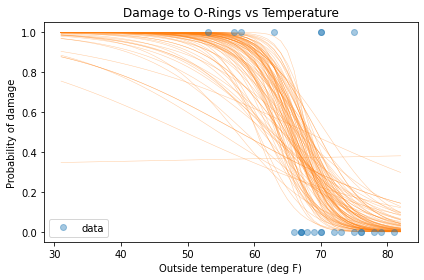

In [134]:
for ps in pred:
    plt.plot(temps, ps, color='C1', lw=0.5, alpha=0.4)
    
plot_data(df)

The overlapping lines in this figure give a sense of the most likely value at each temperature and the degree of uncertainty.

In each column, I’ll compute the median to quantify the central tendency and a 90% credible interval to quantify the uncertainty.

np.percentile computes the given percentiles; with the argument axis=0, it computes them for each column.

In [135]:
low, median, high = np.percentile(pred, [5, 50, 95], axis=0)

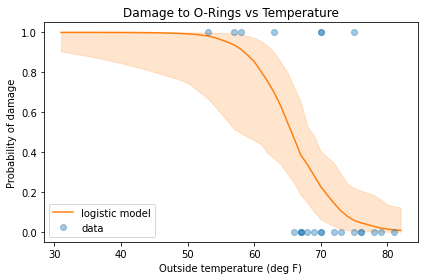

In [136]:
plt.fill_between(temps, low, high, color='C1', alpha=0.2)
plt.plot(temps, median, color='C1', label='logistic model')

plot_data(df)

In [137]:
low = pd.Series(low, temps)
median = pd.Series(median, temps)
high = pd.Series(high, temps)

median.head(5)

31    0.999977
32    0.999969
33    0.999958
34    0.999943
35    0.999921
dtype: float64

In [138]:
t = 80
print(median[t], (low[t], high[t]))

0.013565522106301365 (0.0005525547118990433, 0.1359140917459757)


In [139]:
t = 31
print(median[t], (low[t], high[t]))

0.9999771051974147 (0.9046371694392487, 0.9999999875556395)


One conclusion we might draw is this: If the people responsible for the Challenger launch had taken into account all of the data, and not just the seven damage incidents, they could have predicted that the probability of damage at 31 degrees F was nearly certain. If they had, it seems likely they would have postponed the launch.

At the same time, if they considered the previous figure, they might have realized that the model makes predictions that extend far beyond the data. When we extrapolate like that, we have to remember not just the uncertainty quantified by the model, which we expressed as a credible interval; we also have to consider the possibility that the model itself is unreliable.

This example is based on a logistic model, which assumes that each additional degree of temperature contributes the same amount of evidence in favor of (or against) the possibility of damage. Within a narrow range of temperatures, that might be a reasonable assumption, especially if it is supported by data. But over a wider range, and beyond the bounds of the data, reality has no obligation to stick to the model.

## Empirical bayes

In this chapter I used StatsModels to compute the parameters that maximize the probability of the data, and then used those estimates to choose the bounds of the uniform prior distributions. It might have occurred to you that this process uses the data twice, once to choose the priors and again to do the update. If that bothers you, you are not alone. The process I used is an example of what’s called the Empirical Bayes method, although I don’t think that’s a particularly good name for it.

Although it might seem problematic to use the data twice, in these examples, it is not. To see why, consider an alternative: instead of using the estimated parameters to choose the bounds of the prior distribution, I could have used uniform distributions with much wider ranges. In that case, the results would be the same; the only difference is that I would spend more time computing likelihoods for parameters where the posterior probabilities are negligibly small.

So you can think of this version of Empirical Bayes as an optimization that minimizes computation by putting the prior distributions where the likelihood of the data is worth computing. This optimization doesn’t affect the results, so it doesn’t “double-count” the data.

## Exercises

### 1
Suppose a political pundit claims to be able to predict the outcome of elections, but instead of picking a winner, they give each candidate a probability of winning. With that kind of prediction, it can be hard to say whether it is right or wrong.

For example, suppose the pundit says that Alice has a 70% chance of beating Bob, and then Bob wins the election. Does that mean the pundit was wrong?

One way to answer this question is to consider two hypotheses:

H: The pundit’s algorithm is legitimate; the probabilities it produces are correct in the sense that they accurately reflect the candidates’ probabilities of winning.

not H: The pundit’s algorithm is bogus; the probabilities it produces are random values with a mean of 50%.

If the pundit says Alice has a 70% chance of winning, and she does, that provides evidence in favor of H with likelihood ratio 70/50.

If the pundit says Alice has a 70% chance of winning, and she loses, that’s evidence against H with a likelihood ratio of 50/30.

Suppose we start with some confidence in the algorithm, so the prior odds are 4 to 1. And suppose the pundit generates predictions for three elections:
 
 * In the first election, the pundit says Alice has a 70% chance of winning and she does.
 * In the second election, the pundit says Bob has a 30% chance of winning and he does.
 * In the third election, the pundit says Carol has an 90% chance of winning and she does.

What is the log likelihood ratio for each of these outcomes? Use the log-odds form of Bayes’s Rule to compute the posterior log odds for H after these outcomes. In total, do these outcomes increase or decrease your confidence in the pundit?
 
If you are interested in this topic, you can http://allendowney.blogspot.com/2016/11/why-are-we-so-surprised.html

In [144]:
# log(P(H|x)) = log(P(H)) + x*log(P(x|H) / P(x|notH))

-0.2231435513142097

In [150]:
prior = np.log(4) # this has to be expressed in odds form odds 10:1 become log(10)

data = [
    np.log(70/50),
    np.log(30/50),
    np.log(90/50)
]

print('Prior loglike:', prior)
posterior = prior
for result in data:
    posterior += result
    print('Prob:', expit(posterior))

Prior loglike: 1.3862943611198906
Prob: 0.8484848484848485
Prob: 0.7706422018348623
Prob: 0.8581157775255391


In [151]:
posterior, expit(posterior)

(1.7997276388772319, 0.8581157775255391)

In total, these three outcomes provide evidence that the
pundit's algorithm is legitmate, although with K=1.8,
it is weak evidence.

### 2

An article in the New England Journal of Medicine (https://www.nejm.org/doi/10.1056/NEJMoa1806828) reports results from a study that looked at the diagnosis rate of Attention Deficit Hyperactivity Disorder (ADHD) as a function of birth month: “Attention Deficit–Hyperactivity Disorder and Month of School Enrollment”.

They found that children born in June, July, and August were substantially more likely to be diagnosed with ADHD, compared to children born in September, but only in states that use a September cutoff for children to enter kindergarten. In these states, children born in August start school almost a year younger than children born in September. The authors of the study suggest that the cause is “age-based variation in behavior that may be attributed to ADHD rather than to the younger age of the children”.

In [152]:
# So here is the corrected data, 
# where n is the number of children born in each month, starting with January, and k is the number of children diagnosed with ADHD.

n = np.array([32690, 31238, 34405, 34565, 34977, 34415, 
                   36577, 36319, 35353, 34405, 31285, 31617])

k = np.array([265, 280, 307, 312, 317, 287, 
                      320, 309, 225, 240, 232, 243])

In [238]:
k.sum()/n.sum()

0.00818200987627683

In [246]:
# so it starts in Sept (better intercept?)
x = np.arange(12)
n = np.roll(n, -8)
k = np.roll(k, -8)

In [247]:
adhd = pd.DataFrame(dict(x=x, k=k, n=n))
adhd['rate'] = adhd['k'] / adhd['n'] * 10000
adhd

,x,k,n,rate
0,0,225,35353,63.643821
1,1,240,34405,69.757303
2,2,232,31285,74.156944
3,3,243,31617,76.857387
4,4,265,32690,81.064546
5,5,280,31238,89.634420
6,6,307,34405,89.231216
7,7,312,34565,90.264719
8,8,317,34977,90.630986
9,9,287,34415,83.393869


In [249]:
def plot_adhd(adhd):
    plt.plot(adhd['x'], adhd['rate'], 'o', 
             label='data', color='C0', alpha=0.4)
    
    plt.axvline(5.5, color='gray', alpha=0.2)
    plt.text(6, 64, 'Younger than average')
    plt.text(5, 64, 'Older than average', horizontalalignment='right')

    u.decorate(xlabel='Birth date, months after cutoff',
             ylabel='Diagnosis rate per 10,000')

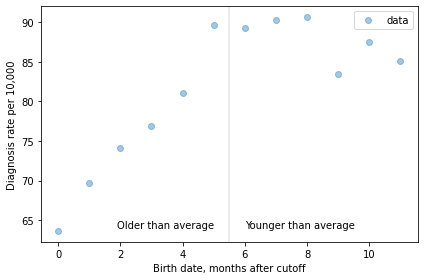

In [250]:
plot_adhd(adhd)

For the first 9 months, from September to May, we see what we would expect if some of the excess diagnoses are due to “age-based variation in behavior”. For each month of difference in age, we see an increase in the number of diagnoses.

This pattern breaks down for the last three months, June, July, and August. This might be explained by random variation, but it also might be due to parental manipulation; if some parents hold back children born near the deadline, the observations for these month would include a mixture of children who are relatively old for their grade and therefore less likely to be diagnosed.

Unfortunately, the dataset includes only month of birth, not year, so we don’t know the actual ages of these students when they started school. However, we can use the first nine months to estimate the effect of age on diagnosis rate; then we can think about what to do with the other three months.

 1) Make a joint prior distribution and update it using the data for the first nine months.
 2) Then draw a sample from the posterior distribution and use it to compute the median probability of diagnosis for each month and a 90% credible interval.
 3) As a bonus exercise, do a second update using the data from the last three months, but treating the observed number of diagnoses as a lower bound on the number of diagnoses there would be if no children were kept back.

In [286]:
prior_inter = u.make_uniform(
    np.linspace(-5.2, -4.6, num=51),
    'intercept'
)
prior_month = u.make_uniform(
    np.linspace(-0.0, 0.08, 51),
    'month'
)
prior_joint = u.make_joint(
    prior_inter, prior_month
)

In [287]:
prior_pmf = ed.Pmf(prior_joint.stack())
prior_pmf

month  intercept
0.00   -5.200       0.000384
       -5.188       0.000384
       -5.176       0.000384
       -5.164       0.000384
       -5.152       0.000384
                      ...   
0.08   -4.648       0.000384
       -4.636       0.000384
       -4.624       0.000384
       -4.612       0.000384
       -4.600       0.000384
Name: , Length: 2601, dtype: float64

In [298]:
likelihood = prior_pmf.copy()
xs = np.arange(9)
ks = k[:9]
ns = n[:9]
for m, i in prior_pmf.index:
    ps = expit(i + m*xs)
    likes = stat.binom.pmf(ks, ns, ps)
    likelihood[m, i] = likes.prod()

In [299]:
posterior = prior_pmf.copy()

posterior *= likelihood
posterior.normalize()

1.3624320717800662e-17

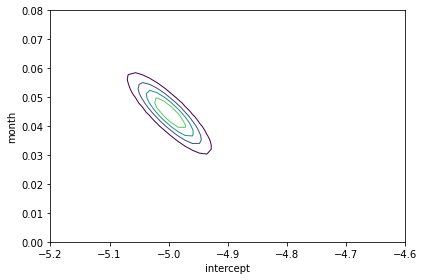

In [300]:
u.plot_contour(posterior.unstack())

In [301]:
posterior.max_prob()

(0.0448, -4.996)

In [305]:
posterior2 = posterior.copy()

xs = np.arange(9, 12)
ks = k[9:]
ns = n[9:]
for m, i in prior_pmf.index:
    ps = expit(i + m*xs)
    likes = stat.binom.sf(ks, ns, ps)
    likelihood[m, i] = likes.prod()

posterior2 *= likelihood
posterior2.normalize()

0.983765899976283

(0.0448, -4.996)


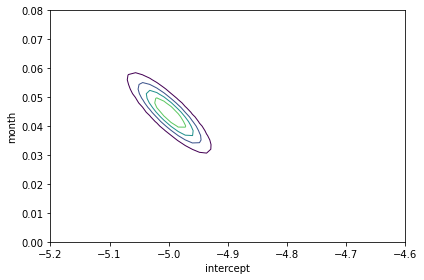

In [306]:
u.plot_contour(posterior2.unstack())
print(posterior2.max_prob())

In [310]:
posterior_un = posterior2.unstack()

marginal_inter = u.marginal(posterior_un, 0)
marginal_slope = u.marginal(posterior_un, 1)

marginal_inter.mean(), marginal_slope.mean()

(-4.999322906782618, 0.044607616771983744)

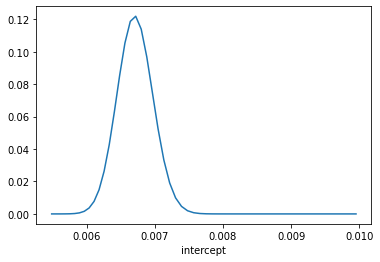

<AxesSubplot: xlabel='month'>

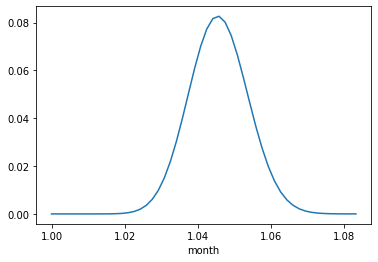

In [316]:
marginal_inter.transform(expit).plot()
plt.show()
plt.close()

marginal_slope.transform(np.exp).plot()

In [320]:
type(posterior2)

empiricaldist.empiricaldist.Pmf

In [332]:
sample = posterior2.choice(200)
# sample_s = sample.stack()

In [333]:
pred_dist = np.empty(
    (len(sample), len(x))
)

for i, (b1, b0) in enumerate(sample):
    pred_dist[i] = expit(b0 + x*b1)

In [334]:
low, median, high = np.percentile(pred_dist, [5, 50, 95], axis=0)

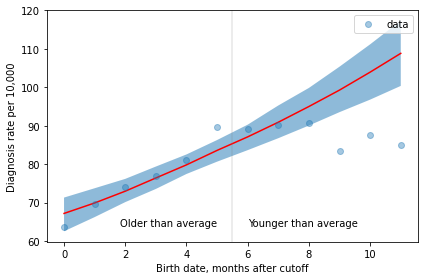

In [335]:
plt.plot(
    x, median*10e3, color='red'
)
plt.fill_between(x, low*10e3, high*10e3, alpha=0.5)

plot_adhd(adhd)

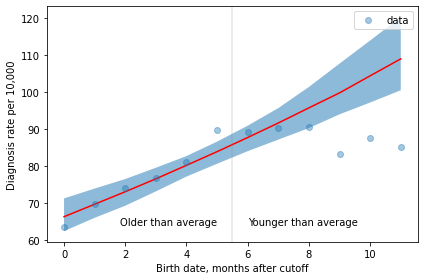

In [331]:
plt.plot(
    x, median*10e3, color='red'
)
plt.fill_between(x, low*10e3, high*10e3, alpha=0.5)

plot_adhd(adhd)

In [350]:
def solve_for_prob(p):
    """return log odds for probability

    Args:
        p (float): probability

    Returns:
        float: log odds
    """
    return -np.log((1-p)/p)

In [565]:
prior = solve_for_prob(0.082)

update = solve_for_prob(312/34565)

posterior = prior + np.log(0.082/(312/34565))
posterior

-0.20892047450423812

In [566]:
prior + np.log(0.082/(312/34565)), expit(prior + np.log(0.082/(312/34565)))

(-0.20892047450423812, 0.447959033138841)

In [567]:
ps = k/n
print(ps.mean(), ps.std())
prior_dist = stat.norm(ps.mean(), ps.std())

0.008176677642147549 0.0008514296829779242


<AxesSubplot: >

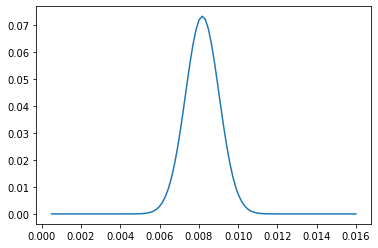

In [568]:
prior_pmf = u.pmf_from_dist(prior_dist, np.linspace(0.0005, 0.016, 100))
prior_pmf.plot()

In [569]:
ps.std(), ps.mean()

(0.0008514296829779242, 0.008176677642147549)

In [570]:
prior_joint = u.make_joint(
    u.make_uniform(np.linspace(0.0005, 0.016, 100), 'mean'),
    u.make_uniform(np.linspace(0.0003514*0.2, 0.00095, 100), 'std'),
)
data = k[9:] / n[9:]
prior_joint

mean,0.000500,0.000657,0.000813,0.000970,0.001126,0.001283,0.001439,0.001596,0.001753,0.001909,...,0.014591,0.014747,0.014904,0.015061,0.015217,0.015374,0.015530,0.015687,0.015843,0.016000
std,,,,,,,,,,,,,,,,,,,,,
0.000070,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,...,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001
0.000079,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,...,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001
0.000088,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,...,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001
0.000097,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,...,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001
0.000106,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,...,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.000914,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,...,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001
0.000923,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,...,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001
0.000932,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,...,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001


In [571]:
mesh_mu, mesh_std, data_mesh = np.meshgrid(prior_joint.columns, prior_joint.index, data)

In [572]:
densities = stat.norm(mesh_mu, mesh_std).pdf(data_mesh)
densities.shape

(100, 100, 3)

In [573]:
dens = densities.prod(axis=2)
dens.shape

(100, 100)

In [574]:
posterior_joint = prior_joint.copy()

posterior_joint *= densities.prod(axis=2)
u.normalize(posterior_joint)

21619942.29081357

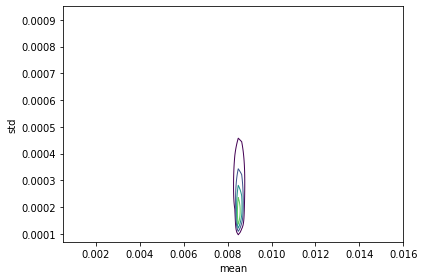

In [575]:
u.plot_contour(posterior_joint)

In [576]:
marginal_mu = u.marginal(posterior_joint, 0)
marginal_std = u.marginal(posterior_joint, 1)

0.008484848484848484


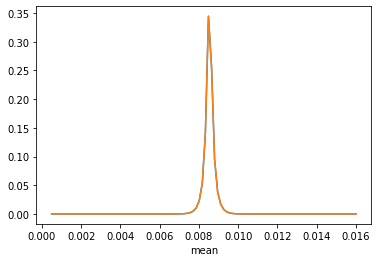

0.00020357090909090908 0.00038758170205191304


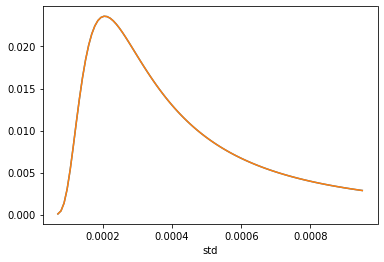

In [577]:
marginal_mu.plot()
print(marginal_mu.max_prob())
marginal_mu.plot()
plt.show()
plt.close()

marginal_std.plot()
print(marginal_std.max_prob(), marginal_std.mean())
marginal_std.plot()
plt.show()
plt.close()


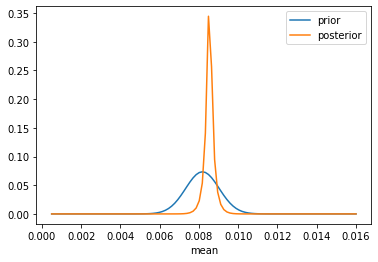

In [578]:

prior_pmf.plot(label='prior')
marginal_mu.plot(label='posterior')
plt.legend()

In [579]:
posterior_pmf = ed.Pmf(posterior_joint.stack())
sample = posterior_pmf.choice(200)
posterior_pmf

std      mean    
0.00007  0.000500    0.000000e+00
         0.000657    0.000000e+00
         0.000813    0.000000e+00
         0.000970    0.000000e+00
         0.001126    0.000000e+00
                         ...     
0.00095  0.015374    5.326467e-38
         0.015530    1.453274e-39
         0.015687    3.654835e-41
         0.015843    8.472287e-43
         0.016000    1.810281e-44
Name: , Length: 10000, dtype: float64

In [580]:
like_h0 = stat.norm(0.0082, 0.000851).pdf(312/34565)
like_h1 = stat.norm(marginal_mu.max_prob(), marginal_std.mean()).pdf(312/34565)

In [583]:
like_h0/like_h1, like_h1/like_h0, expit(like_h1/like_h0)

(0.7545343412272351, 1.3253207247976546, 0.790065574419668)

In [470]:
mu = marginal_mu.max_prob()
std = marginal_std.mean()

xs = np.linspace(mu-4*std, mu+4*std, 200)

In [477]:
a = np.empty((200, 200))

for i, (s, m) in enumerate(sample):
    densities = stat.norm(m, s).pdf(xs)
    a[i] = densities

In [486]:
a.shape

(200, 200)

In [505]:
test = ed.Pmf(a.prod(axis=0), xs)
test.normalize()

c:\Users\marek.kancir\Anaconda3\envs\scraping_env\lib\site-packages\numpy\core\_methods.py:51: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)


inf

In [243]:
from typing import Iterable
import re

def check_ending(url):
    if isinstance(url, str):
        if url.endswith('/'):
            return url
        else:
            if url == '':
                return ''
            return url + '/'
    elif url is None:
        return ''
    else:
        raise TypeError(f'URL should be string type. Passed {type(url)}')
def build_url(url_root, url_spec=None, query=[]):
    url_root, url_spec = check_ending(url_root), check_ending(url_spec)
    if isinstance(query, Iterable):
        if len(query)>0:
            query_full ='?' + '&'.join(query)
            url_spec = re.sub(r'/{2,}', r'/', url_spec)[:-1]
        else:
            query_full = ''
    else:
        raise TypeError(f'query should be iterable! You passed {type(query)}')
    return re.sub(r'([a-zA-Z])/{2,}', r'\1/', f'{url_root}{url_spec}{query_full}')

In [244]:
build_url('http://www.somerandom.com////', '//some//subPage///', ['param=1', 'something=true'])

'http://www.somerandom.com/some/subPage?param=1&something=true'

In [245]:
build_url('http://www.somerandom.com////', '//some//subPage///')

'http://www.somerandom.com/some/subPage/'

In [176]:
s= '//'

In [184]:
re.sub('\/+', '/', s)

'/'